In [11]:
!curl -o ETTh1.csv https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

/bin/bash: line 1: curl: command not found


In [1]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


### Configs

In [2]:
input_size = 336
label_size = 96
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 5
target_name = 'OT'
date_column = 'date'
file_path = '../assets/ETTh1.csv'

plot_dir = 'plots'
weight_dir = 'weights'
results =  []

### Data preparation

In [3]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f'Offset will be change from {offset} to {label_size}')
            offset = label_size
        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        self.df = pl.read_csv(file_path)
        if date_column is not None: 
            self.df = self.df.drop('date')
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError('Features type must be S, M or MS')
        
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size*len(self.df)))
        print(f'{self.X_train.shape=}')
        print(f'{self.y_train.shape=}')
        self.X_val, self.y_val = self.__create_dataset(int(train_size*len(self.df)), int((train_size+val_size)*len(self.df)))
        print(f'{self.X_val.shape=}')
        print(f'{self.y_val.shape=}')
        self.X_test, self.y_test = self.__create_dataset(int((train_size+val_size)*len(self.df)), None)

        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset
        start_idx += self.input_size + self.offset
        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset 
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError('Features type must be S, M or MS')
            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns
        return np.array(features), np.array(labels)
    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


In [4]:
features_type = 'MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape=(11762, 336, 7)
self.y_train.shape=(11762, 96, 1)
self.X_val.shape=(1309, 336, 7)
self.y_val.shape=(1309, 96, 1)


In [5]:
features_type = 'M'
sub_dir = 'multi2multi'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2multi_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape=(11762, 336, 7)
self.y_train.shape=(11762, 96, 7)
self.X_val.shape=(1309, 336, 7)
self.y_val.shape=(1309, 96, 7)


In [6]:
multi2multi_loader.X_test[1]

array([[ 3.68400002,  2.21000004, -0.71100003, ...,  4.11199999,
         0.94400001,  3.79900002],
       [13.32900047,  2.74600005,  8.49300003, ...,  4.72100019,
         0.82200003,  3.58800006],
       [15.60599995,  2.94700003, 10.27000046, ...,  5.23899984,
         0.91399997,  3.79900002],
       ...,
       [10.85099983,  1.40699995,  6.75199986, ...,  4.17299986,
         0.60900003,  3.09500003],
       [11.65499973,  1.54100001,  7.42700005, ...,  4.26399994,
         0.579     ,  3.09500003],
       [13.39599991,  1.80799997,  9.02600002, ...,  4.44700003,
         0.54799998,  3.16599989]])

### Training MOdel Preparation

In [7]:
class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.0001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.train_loss_per_epoch = []
        self.val_loss_per_epoch = []

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            total_train_loss = 0
            for inputs, targets in self.train_loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            avg_train_loss = total_train_loss / len(self.train_loader)
            val_loss = self.evaluate(loader=self.val_loader) 

            if self.early_stopping(val_loss, save_path):
                print(f'Early stopping on epoch {epoch + 1}')
                return
            print(f'Epoch {epoch + 1}/{num_epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, time: {time.time() - start_time:.2f}s')
        self.save_model(save_path)
    
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience
    
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')
    
    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')
    
    def predict(self, input_data):
        self.model.eval()
        if isinstance(input_data, DataLoader):
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)
        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None: 
            feature_names = [f'Feature {i+1}' for i in range(y.shape[2])]
            
        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10,5))
            plt.plot(y[:,:,feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:,:,feature_index].flatten(), label='y_hat', linestyle='--')
            plt.title(f'{feature_name} Forecast')
            plt.xlabel('Time Steps')
            plt.ylabel('Values')
            plt.legend()
            if save_plots:
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)
            plt.show()
            plt.close()
class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval
    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)
    
    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')
    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain), self.preprocessing(self.ytrain),eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best={self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)
    def predict(self, x):
        return self.model.predict(self.preprocessing(x))
    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        return mean_absolute_error(self.preprocessing(y), self.preprocessing(x))
    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

In [8]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.1,
    'early_stopping_rounds': patience,
}

In [9]:
XGBoost_multi2multi = XGBRegressor(**xgboost_config)
XGBoost_multi2multi_manager = MachineLearningModelManager(model = XGBoost_multi2multi, xtrain = multi2multi_loader.X_train, ytrain = multi2multi_loader.y_train, xval = multi2multi_loader.X_val, yval = multi2multi_loader.y_val)
XGBoost_multi2multi_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2multi_manager.evaluate(x=multi2multi_loader.X_test, y=multi2multi_loader.y_test)
})
results[-1]

[0]	validation_0-mae:3.43701
[1]	validation_0-mae:3.26450
[2]	validation_0-mae:3.12015
[3]	validation_0-mae:2.99788
[4]	validation_0-mae:2.89048
[5]	validation_0-mae:2.79511
[6]	validation_0-mae:2.71269
[7]	validation_0-mae:2.64030
[8]	validation_0-mae:2.57559
[9]	validation_0-mae:2.51784
[10]	validation_0-mae:2.46626
[11]	validation_0-mae:2.42100


KeyboardInterrupt: 

In [ ]:
# Generate predictions on the training data
test_predictions = LSTM_multi2multi_manager.predict(multi2multi_loader.train_loader)

# Get the true values
y_true = multi2multi_loader.y_train

# Plot the true values against the predictions
LSTM_multi2multi_manager.plot(y=y_true, yhat=test_predictions, feature_names=["HUFL","HULL","MUFL","MULL","LUFL","LULL","OT"], num_elements=4, save_plots=False)

In [32]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)
        self.ahead = ahead
        self.output_size=output_size
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)

In [ ]:
MLP_multi2uni = MLP(input_size=multi2uni_loader.in_variable*input_size, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size)

MLP_multi2uni_manager = ModelManager(model=MLP_multi2uni, train_loader=multi2uni_loader.train_loader,val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
MLP_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    'MAE': MLP_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

In [72]:
x = multi2uni_loader.X_train
x.shape

(11762, 336, 7)

In [80]:
x= multi2uni_loader.train_loader

AttributeError: 'DataLoader' object has no attribute 'y_train'

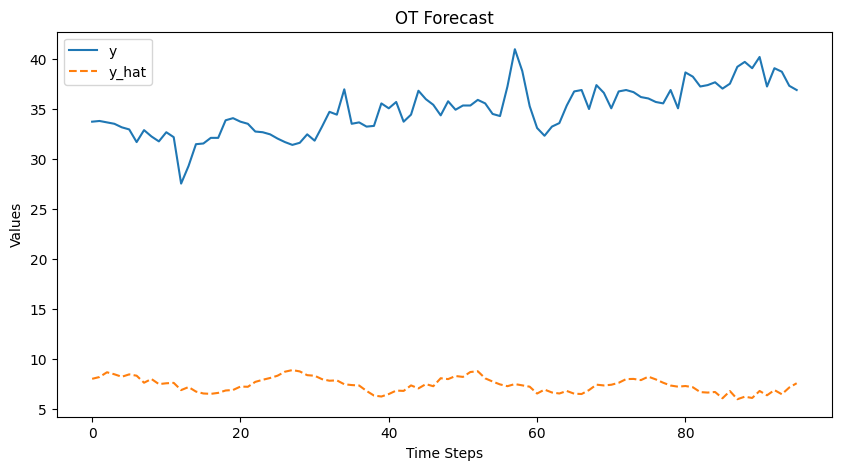

In [90]:
# Generate predictions on the training data
test_predictions = MLP_multi2uni_manager.predict(multi2uni_loader.train_loader)

# Get the true values
y_true = multi2uni_loader.y_train

# Plot the true values against the predictions
MLP_multi2uni_manager.plot(y=y_true, yhat=test_predictions, feature_names=['OT'], num_elements=1)

ValueError: too many values to unpack (expected 2)

In [77]:
len(test_targets)

64

In [76]:
test_targets.shape

torch.Size([64, 96, 1])

In [40]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [41]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)

LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)

LSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})      

results[-1]


/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 96, 1])) that is different to the input size (torch.Size([64, 96, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([50, 96, 1])) that is different to the input size (torch.Size([50, 96, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([29, 96, 1])) that is different to the input size (torch.Size([29, 96, 7]

Model saved to weights/multi2multi/best-LSTM.pth
Epoch 1/1000000, train_loss: 10.1477, val_loss: 8.2267, time: 38.76s
Epoch 2/1000000, train_loss: 6.2537, val_loss: 11.2143, time: 29.03s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 3/1000000, train_loss: 6.0879, val_loss: 7.0469, time: 28.59s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 4/1000000, train_loss: 4.3576, val_loss: 5.0302, time: 21.05s
Epoch 5/1000000, train_loss: 3.5280, val_loss: 5.7553, time: 24.38s
Epoch 6/1000000, train_loss: 3.1669, val_loss: 6.4820, time: 28.05s
Epoch 7/1000000, train_loss: 2.8095, val_loss: 6.4279, time: 29.02s
Epoch 8/1000000, train_loss: 2.5714, val_loss: 6.4377, time: 27.70s
Epoch 9/1000000, train_loss: 2.3972, val_loss: 6.5103, time: 27.58s
Epoch 10/1000000, train_loss: 2.2899, val_loss: 6.6362, time: 27.05s
Epoch 11/1000000, train_loss: 2.2332, val_loss: 6.5645, time: 27.09s
Epoch 12/1000000, train_loss: 2.1694, val_loss: 6.3304, time: 26.24s
Epoch 13/1000000, train_loss: 2.

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 7.304619566599528}

In [95]:
y_true.shape

(11762, 96, 7)

In [96]:
test_predictions.shape

torch.Size([11762, 96, 7])

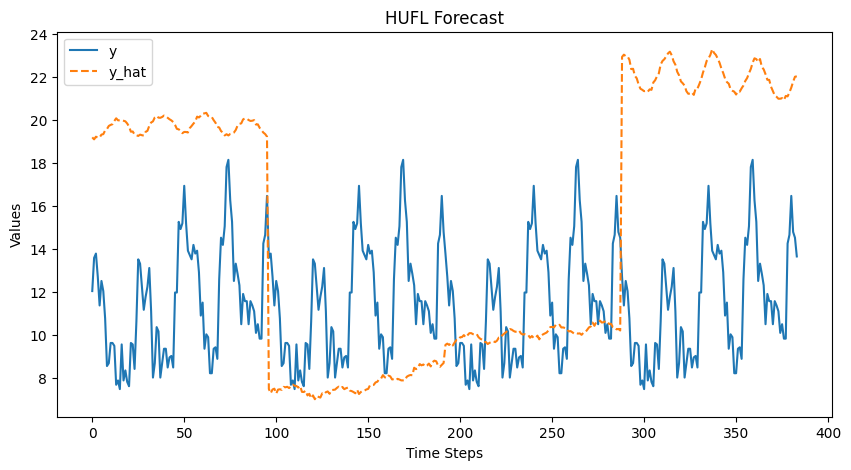

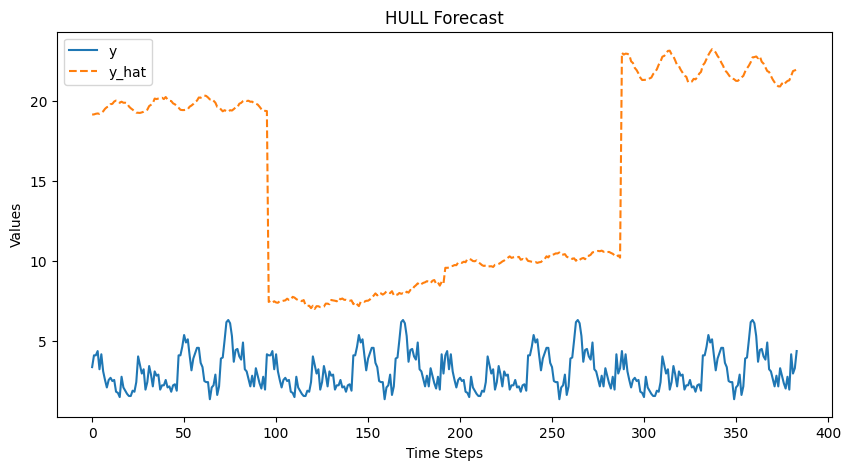

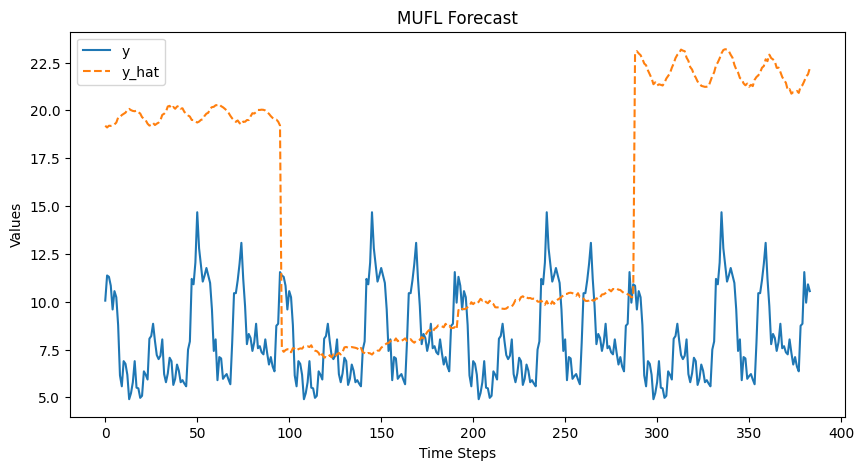

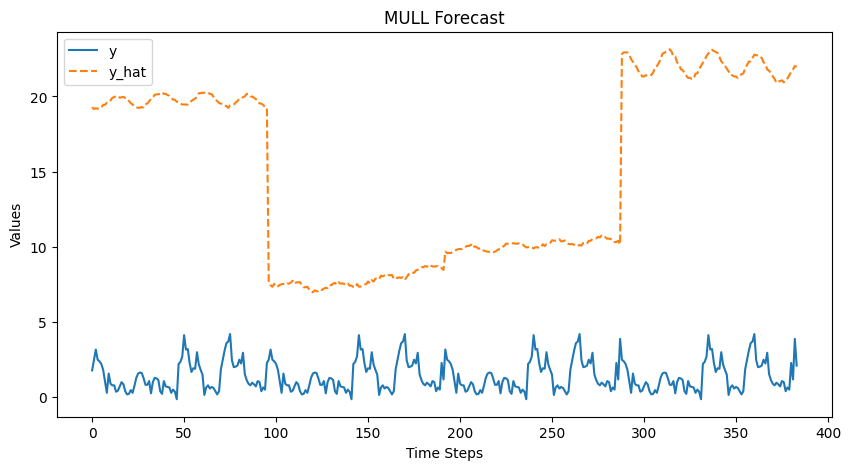

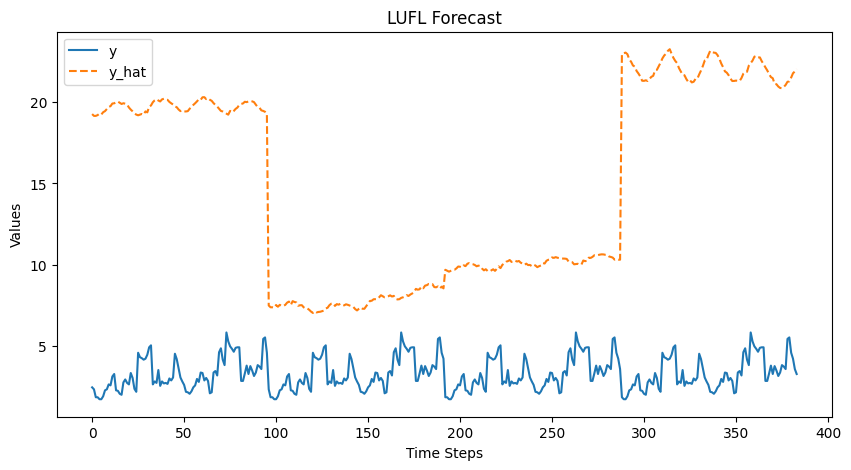

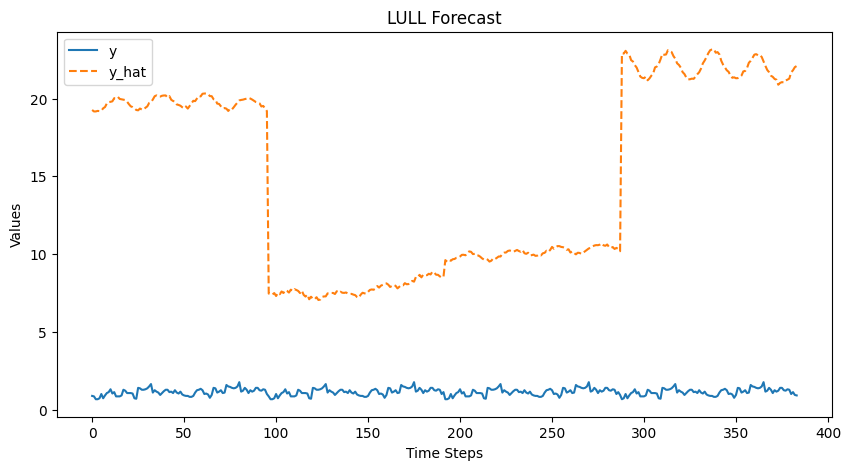

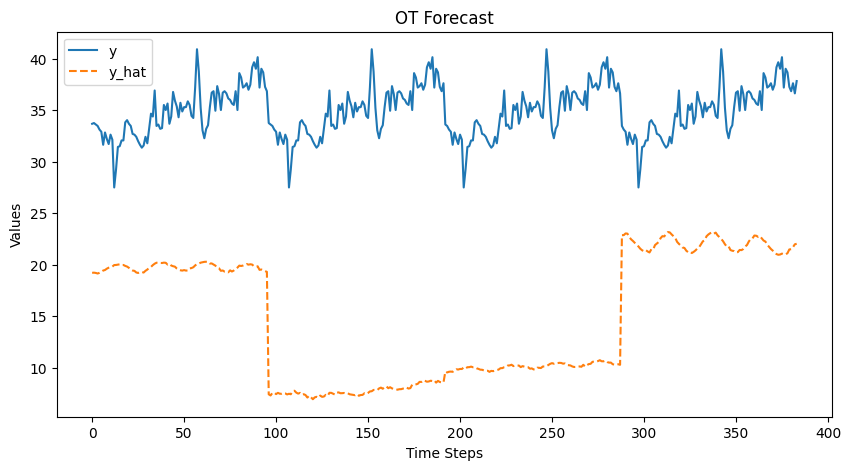

In [94]:
# Generate predictions on the training data
test_predictions = LSTM_multi2multi_manager.predict(multi2multi_loader.train_loader)

# Get the true values
y_true = multi2multi_loader.y_train

# Plot the true values against the predictions
LSTM_multi2multi_manager.plot(y=y_true, yhat=test_predictions, feature_names=["HUFL","HULL","MUFL","MULL","LUFL","LULL","OT"], num_elements=4)

In [42]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size, num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-LSTM.pth
Epoch 1/1000000, train_loss: 10.1028, val_loss: 8.2895, time: 45.24s
Epoch 2/1000000, train_loss: 6.2407, val_loss: 11.2853, time: 38.38s
Epoch 3/1000000, train_loss: 6.1142, val_loss: 11.4676, time: 35.74s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 4/1000000, train_loss: 5.7244, val_loss: 5.6687, time: 35.30s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 5/1000000, train_loss: 3.9237, val_loss: 5.2450, time: 26.41s
Epoch 6/1000000, train_loss: 3.4281, val_loss: 5.5760, time: 26.88s
Epoch 7/1000000, train_loss: 3.1199, val_loss: 5.2714, time: 27.97s
Epoch 8/1000000, train_loss: 2.8517, val_loss: 5.7720, time: 28.08s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 9/1000000, train_loss: 2.6984, val_loss: 5.1645, time: 30.89s
Epoch 10/1000000, train_loss: 2.5935, val_loss: 5.7579, time: 28.73s
Epoch 11/1000000, train_loss: 2.5323, val_loss: 6.7428, time: 27.93s
Epoch 12/1000000, train_loss: 2.4500, val_loss: 6.3

KeyboardInterrupt: 

In [92]:
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 36.09023829868862}

In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [79]:
RNN_multi2uni = RNN(input_size = multi2uni_loader.in_variable, hidden_size = hidden_size, output_size = multi2uni_loader.out_variable, ahead = label_size, num_layers=num_layers)
RNN_multi2uni = ModelManager(model=RNN_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
RNN_multi2uni.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2uni.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2uni.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch 1/1000000, train_loss: 63.2555, val_loss: 95.1433, time: 0.12s
Epoch 2/1000000, train_loss: 63.2324, val_loss: 95.4776, time: 0.11s
Epoch 3/1000000, train_loss: 63.2189, val_loss: 95.2150, time: 0.12s
Epoch 4/1000000, train_loss: 63.2141, val_loss: 95.3013, time: 0.12s
Epoch 5/1000000, train_loss: 63.1907, val_loss: 95.1751, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 6/1000000, train_loss: 63.1813, val_loss: 94.8467, time: 0.12s
Epoch 7/1000000, train_loss: 63.1917, val_loss: 95.0604, time: 0.12s
Epoch 8/1000000, train_loss: 63.1813, val_loss: 94.9795, time: 0.12s
Epoch 9/1000000, train_loss: 63.1564, val_loss: 95.0982, time: 0.12s
Epoch 10/1000000, train_loss: 63.1138, val_loss: 94.9423, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 11/1000000, train_loss: 63.1026, val_loss: 94.8319, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 12/1000000, train_loss: 63.1343, val_loss

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 26.633978162493026}

In [75]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,output_size = multi2multi_loader.out_variable,ahead=label_size,num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,train_loader=multi2multi_loader.train_loader,val_loader=multi2multi_loader.val_loader,lr=learning_rate,patience=patience)
RNN_multi2multi_manager.train(num_epochs=num_epochs,save_dir=os.path.join(weight_dir,sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch 1/1000000, train_loss: 28.0154, val_loss: 31.4907, time: 0.21s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 2/1000000, train_loss: 27.9980, val_loss: 31.4725, time: 0.13s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 3/1000000, train_loss: 27.9787, val_loss: 31.4405, time: 0.14s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 4/1000000, train_loss: 27.9658, val_loss: 31.4092, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 5/1000000, train_loss: 27.9376, val_loss: 31.3888, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 6/1000000, train_loss: 27.9106, val_loss: 31.3490, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 7/1000000, train_loss: 27.8725, val_loss: 31.3124, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 8/1000000, train_loss: 27.8392, val_loss: 31.2718, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 9/1000000,

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 4.871362004961286}

In [155]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [156]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size, output_size=multi2multi_loader.out_variable, ahead=label_size, num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi, train_loader=multi2multi_loader.train_loader, val_loader=multi2multi_loader.val_loader, lr=learning_rate, patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 1/1000000, train_loss: 28.0771, val_loss: 28.5293, time: 0.18s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 2/1000000, train_loss: 28.1725, val_loss: 28.4454, time: 0.16s
Epoch 3/1000000, train_loss: 28.1697, val_loss: 28.4727, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 4/1000000, train_loss: 28.1379, val_loss: 28.4028, time: 0.16s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 5/1000000, train_loss: 28.0767, val_loss: 28.3754, time: 0.15s
Epoch 6/1000000, train_loss: 28.0432, val_loss: 28.4054, time: 0.15s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 7/1000000, train_loss: 27.9546, val_loss: 28.2997, time: 0.17s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 8/1000000, train_loss: 27.9362, val_loss: 28.2525, time: 0.16s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 9/1000000, train_loss: 27.9498, val_loss: 28.1432, time: 0.16s
Model saved to weights

{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 4.806035391489664}

In [96]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size, num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 1/1000000, train_loss: 63.2115, val_loss: 95.1277, time: 0.48s
Epoch 2/1000000, train_loss: 63.1705, val_loss: 95.2383, time: 0.38s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 3/1000000, train_loss: 63.1975, val_loss: 95.0263, time: 0.38s
Epoch 4/1000000, train_loss: 63.1768, val_loss: 95.1357, time: 0.38s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 5/1000000, train_loss: 63.1657, val_loss: 94.9034, time: 0.38s
Epoch 6/1000000, train_loss: 63.1810, val_loss: 95.1116, time: 0.38s
Epoch 7/1000000, train_loss: 63.1545, val_loss: 95.1430, time: 0.38s
Epoch 8/1000000, train_loss: 63.1553, val_loss: 95.1340, time: 0.38s
Epoch 9/1000000, train_loss: 63.1617, val_loss: 95.0761, time: 0.38s
Epoch 10/1000000, train_loss: 63.1216, val_loss: 95.1403, time: 0.38s
Epoch 11/1000000, train_loss: 63.1220, val_loss: 95.0321, time: 0.38s
Epoch 12/1000000, train_loss: 63.1126, val_loss: 94.9038, time: 0.37s
Model saved to w

{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 27.172881807599747}